# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение, количество детей, доход клиента или цели кредита на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Изучение датасета

Импортируем библиотеки, которые понадобятся в проекте

In [1]:
import pandas as pd
from pymystem3 import Mystem
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

Сохраним файл в переменную clients, затем выведем первые 10 строк таблицы для ознакомления

In [2]:
clients = pd.read_csv('credit_data.csv')

In [3]:
clients.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Получим сводную информацию о данных в таблице

In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Для дальнейшего удобства в работе с таблицей заменим название некоторых столбцов на более информативное.

Названия столбцов на входе:
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

После переименования:
- children_number — количество детей в семье
- work_experience_days — общий трудовой стаж в днях
- client_age — возраст клиента в годах
- education_level — уровень образования клиента
- education_level_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- employment_type — тип занятости
- debt_status — имел ли задолженность по возврату кредитов
- month_income — ежемесячный доход
- credit_purpose — цель получения кредита



- work_experience_years — общий трудовой стаж в годах (_прим. этот признак будет добавлен позже при работе с аномальными значениями, на этапе чтения файла его нет_)

In [5]:
clients.set_axis(['children_number', 'work_experience_days', 'client_age', 'education_level',
                  'education_level_id', 'family_status', 'family_status_id', 'gender',
                  'employment_type', 'debt_status', 'month_income', 'credit_purpose'],
                  axis='columns',inplace=True)

После переименования столбцов еще раз проверим данные методом info()

In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   children_number       21525 non-null  int64  
 1   work_experience_days  19351 non-null  float64
 2   client_age            21525 non-null  int64  
 3   education_level       21525 non-null  object 
 4   education_level_id    21525 non-null  int64  
 5   family_status         21525 non-null  object 
 6   family_status_id      21525 non-null  int64  
 7   gender                21525 non-null  object 
 8   employment_type       21525 non-null  object 
 9   debt_status           21525 non-null  int64  
 10  month_income          19351 non-null  float64
 11  credit_purpose        21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Посмотрим на данные методом describe()

In [7]:
clients.describe()

,children_number,work_experience_days,client_age,education_level_id,family_status_id,debt_status,month_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Вывод**

В файле представлена информация о клиентах банка и их платежеспособности. 

Таблица содержит 21525 записей и 12 столбцов с разными типами данных: int64, float64 и object. Запись равна одному объекту исследования (клиенту).

Названия столбцов представлены в правильном формате (все в нижнем регистре и вместо пробелов нижнее подчеркивание). Но, если говорить о названии столбцов с точки зрения информативности, то некоторые потребовалось переименовать на более понятные.

На первый взгляд наблюдаем следующие проблемы:

- в столбце с трудовым стажем (work_experience_days (до переименования - days_employed)) есть пропущенные, отрицательные или очень большие значения, также количество дней указано как вещественные числа;


- в столбце с уровнем образования клиента (education_level (до переименования - education)) значения представлены с разным регистром;


- в столбце с ежемесячным доходом клиента (month_income (до переименования total_income)) есть пропуски. Также доходы указаны в виде вещественных чисел с шестью знаками после разделителя;


- в столбце с количеством детей клиента есть отрицательные значения. Максимальноен количество детей достигает аномального значения 20.

Для ответов на поставленные бизнесом вопросы нам потребуются столбцы со следующей информацией:
количество детей, семейное положение, ежемесячный доход, цель кредита и имелась ли у клиента задолженность по кредитам. 

## Предобработка данных

### Обработка аномальных значений

Посмотрим на средние значения трудового стажа в разрезе типов занятости

In [8]:
clients.groupby('employment_type')['work_experience_days'].mean()

employment_type
безработный        366413.652744
в декрете           -3296.759962
госслужащий         -3399.896902
компаньон           -2111.524398
пенсионер          365003.491245
предприниматель      -520.848083
сотрудник           -2326.499216
студент              -578.751554
Name: work_experience_days, dtype: float64

Мы видим аномалии положительного и отрицательного стажа. 
Положительный стаж наблюдается только у безработных и пенсионеров, при этом он выглядит слишком большим. Похоже на то, что стаж измерялся в часах, поэтому дополнительно будем делить его на 24. 
Отрицательный стаж приведем к абсолютным значениям с помощью метода abs(). Просто удалить все строки с отрицательным стажем нельзя, т.к. мы потеряем огромное количество данных для анализа. 

In [9]:
clients['work_experience_days'] = clients['work_experience_days'].apply(lambda x: x/24 if x>0  else abs(x))

Создадим новый признак трудового стажа в годах, для этого поделим стаж в днях для всех типов занятости на 365

In [10]:
clients['work_experience_years'] = clients['work_experience_days']/365

Посмотрим, что получилось и убедимся, что в трудовом стаже не осталось аномальных значений 

In [11]:
clients.describe()

,children_number,work_experience_days,client_age,education_level_id,family_status_id,debt_status,month_income,work_experience_years
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04,19351.000000
mean,0.538908,4641.641176,43.293380,0.817236,0.972544,0.080883,1.674223e+05,12.716825
std,1.381587,5355.964289,12.574584,0.548138,1.420324,0.272661,1.029716e+05,14.673875
min,-1.000000,24.141633,0.000000,0.000000,0.000000,0.000000,2.066726e+04,0.066141
25%,0.000000,927.009265,33.000000,1.000000,0.000000,0.000000,1.030532e+05,2.539751
50%,0.000000,2194.220567,42.000000,1.000000,0.000000,0.000000,1.450179e+05,6.011563
75%,1.000000,5537.882441,53.000000,1.000000,1.000000,0.000000,2.034351e+05,15.172281
max,20.000000,18388.949901,75.000000,4.000000,4.000000,1.000000,2.265604e+06,50.380685


Также у нас остался еще один столбец с аномальными значениями - количество детей. Методом abs() приведем отрицательные знаечния к абсолютным.

In [12]:
clients['children_number'] = clients['children_number'].abs()

Теперь посмотрим на максимальное количество детей 20. Посчитаем количество таких записей и посмотрим нет ли еще анамальных положительных значений

In [13]:
clients['children_number'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children_number, dtype: int64

Как видим, есть 76 записей с количеством детей - 20. Похоже, что это была опечатка, например, при вводе 2х детей не убрали 0, который стоял по умолчанию. Заменим 20 на 2 методом replace() и убедимся, что данные по столбцу теперь корректны

In [14]:
clients['children_number'] = clients['children_number'].replace(20,2)

In [15]:
clients['children_number'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children_number, dtype: int64

Проверим данные

In [16]:
clients.describe()

,children_number,work_experience_days,client_age,education_level_id,family_status_id,debt_status,month_income,work_experience_years
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04,19351.000000
mean,0.479721,4641.641176,43.293380,0.817236,0.972544,0.080883,1.674223e+05,12.716825
std,0.755528,5355.964289,12.574584,0.548138,1.420324,0.272661,1.029716e+05,14.673875
min,0.000000,24.141633,0.000000,0.000000,0.000000,0.000000,2.066726e+04,0.066141
25%,0.000000,927.009265,33.000000,1.000000,0.000000,0.000000,1.030532e+05,2.539751
50%,0.000000,2194.220567,42.000000,1.000000,0.000000,0.000000,1.450179e+05,6.011563
75%,1.000000,5537.882441,53.000000,1.000000,1.000000,0.000000,2.034351e+05,15.172281
max,5.000000,18388.949901,75.000000,4.000000,4.000000,1.000000,2.265604e+06,50.380685


### Обработка пропусков

В первой части проекта методом info() мы увидели наличие пропусков в столбцах с трудовым стажем и ежемесячным доходом, посмотрим на количество пропущенных значений методом isna(). Между isna() и isnull() выбран isna(), т.к. пропущенные значения были замечены в столбцах с типом данных float64. Если бы пропущенные значения были в столбцах с разыми типами данных, то предпочтение было бы методу isnull().

In [17]:
clients.isna().sum()

children_number             0
work_experience_days     2174
client_age                  0
education_level             0
education_level_id          0
family_status               0
family_status_id            0
gender                      0
employment_type             0
debt_status                 0
month_income             2174
credit_purpose              0
work_experience_years    2174
dtype: int64

Т.к. далее мы будем использовать признак трудового стажа в годах, столбец с трудовым стажем в днях можно удалить. 

In [18]:
clients = clients.drop(columns='work_experience_days')

Мы видим одинаковое количество строк с пропусками с трудовом стаже и ежемесячном доходе. Удаление строк с пропущенными значениями повлечет удаление большого количества данных для анализа, поэтому лучше заполнить пропуски средними значениями

Прежде, чем мы начнем расчет среднего значения, посмотрим на таблицу еще раз на примере сотрировки данных по столбцам с количеством лет стажа и ежемесячным доходом. 
Видно, что самое большое количество лет стажа у пенсионеров, а наименьшее - у сотрудников и компаньонов. При этом уровень дохода у пенсионеров ниже. Исходя из этого приходим к выводу, что средние значения лучше рассчитывать по каждому типу занятости отдельно

In [19]:
clients.sort_values(by='work_experience_years', ascending = False)

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,employment_type,debt_status,month_income,credit_purpose,work_experience_years
16335,1,61,среднее,1,женат / замужем,0,F,сотрудник,0,186178.934089,операции с недвижимостью,50.380685
4299,0,61,среднее,1,женат / замужем,0,F,компаньон,0,122560.741753,покупка жилья,48.261817
6954,0,56,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278.441171,ремонт жилью,45.862489
10006,0,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования,45.857969
7664,1,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем,45.853321
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем,NaN
21495,1,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба,NaN
21497,0,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости,NaN
21502,1,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости,NaN


In [20]:
clients.sort_values(by='month_income', ascending = False)

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,employment_type,debt_status,month_income,credit_purpose,work_experience_years
12412,0,44,высшее,0,женат / замужем,0,M,компаньон,0,2.265604e+06,ремонт жилью,4.047776
19606,1,39,высшее,0,женат / замужем,0,M,компаньон,1,2.200852e+06,строительство недвижимости,7.062095
9169,1,35,среднее,1,гражданский брак,1,M,сотрудник,0,1.726276e+06,дополнительное образование,14.379601
20809,0,61,среднее,1,Не женат / не замужем,4,F,сотрудник,0,1.715018e+06,покупка жилья для семьи,12.929516
17178,0,42,высшее,0,гражданский брак,1,M,компаньон,0,1.711309e+06,сыграть свадьбу,15.709937
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем,NaN
21495,1,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба,NaN
21497,0,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости,NaN
21502,1,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости,NaN


Посмотрим для каких типов занятости в таблице есть пропуски по трудовому стажу

In [21]:
clients[clients['work_experience_years'].isna()].groupby('employment_type').count()

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,debt_status,month_income,credit_purpose,work_experience_years
employment_type,,,,,,,,,,,
госслужащий,147,147,147,147,147,147,147,147,0,147,0
компаньон,508,508,508,508,508,508,508,508,0,508,0
пенсионер,413,413,413,413,413,413,413,413,0,413,0
предприниматель,1,1,1,1,1,1,1,1,0,1,0
сотрудник,1105,1105,1105,1105,1105,1105,1105,1105,0,1105,0


Аналогично выявляем пропуски в ежемесячном доходе 

In [22]:
clients[clients['month_income'].isna()].groupby('employment_type').count()

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,debt_status,month_income,credit_purpose,work_experience_years
employment_type,,,,,,,,,,,
госслужащий,147,147,147,147,147,147,147,147,0,147,0
компаньон,508,508,508,508,508,508,508,508,0,508,0
пенсионер,413,413,413,413,413,413,413,413,0,413,0
предприниматель,1,1,1,1,1,1,1,1,0,1,0
сотрудник,1105,1105,1105,1105,1105,1105,1105,1105,0,1105,0


Как мы видим, пропуски присутствуют в трудовом стаже и ежемесячном доходе не для всех типов занятости. Среднее значение будем рассчитывать только для тех типов занятости, где есть пропуски.

Сформируем сводные таблицы с группировкой по типу занятости и измерением трудового стажа. Выбрано среднее значение, а не медиана, т.к. при просмотре отсортированной таблицы выше не наблюдается артефактов. Например, большое значение стажа свыше 400000 дней одинаково у первых пяти записей и это пенисионеры

In [23]:
group_experience = clients.groupby('employment_type')['work_experience_years'].mean()

Используя цикл заполним пропуски средним значением стажа по типу занятости

In [24]:
for i in group_experience.index:

    clients.loc[(clients['employment_type'] == i) & (
        clients['work_experience_years'].isna()), 'work_experience_years'] = group_experience[i]

Аналогично заполнению пропусков для стажа сделаем сводную таблицу с группировкой по типу занятости и доходам. Также выбираем среднее значение, а не медиану, т.к. суммы дохода не выбиваются из общей картины ни с наибольшими, ни с наименьшими значениями.

In [25]:
group_income = clients.groupby('employment_type')['month_income'].mean()

Используя цикл заполним пропуски средним значением дохода по типу занятости

In [26]:
for i in group_income.index:

    clients.loc[(clients['employment_type'] == i) & (
        clients['month_income'].isna()), 'month_income'] = group_income[i]

Применяем к таблице метод isna() и видим, что пропусков не осталось

In [27]:
clients.isna().sum()

children_number          0
client_age               0
education_level          0
education_level_id       0
family_status            0
family_status_id         0
gender                   0
employment_type          0
debt_status              0
month_income             0
credit_purpose           0
work_experience_years    0
dtype: int64

Не всегда пропуски обозначены явно. Посмотрим на статистику по таблице с учетом нечисловых столбцов. Мы видим странное количество уникальных значений в столбце с полом, равное трем, а также значение минимального возраста клиента, равное 0

In [28]:
clients.describe(include = 'all')

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,employment_type,debt_status,month_income,credit_purpose,work_experience_years
count,21525.000000,21525.000000,21525,21525.000000,21525,21525.000000,21525,21525,21525.000000,2.152500e+04,21525,21525.000000
unique,NaN,NaN,15,NaN,5,NaN,3,8,NaN,NaN,38,NaN
top,NaN,NaN,среднее,NaN,женат / замужем,NaN,F,сотрудник,NaN,NaN,свадьба,NaN
freq,NaN,NaN,13750,NaN,12380,NaN,14236,11119,NaN,NaN,797,NaN
mean,0.479721,43.293380,NaN,0.817236,NaN,0.972544,NaN,NaN,0.080883,1.673959e+05,NaN,12.759326
std,0.755528,12.574584,NaN,0.548138,NaN,1.420324,NaN,NaN,0.272661,9.790695e+04,NaN,14.592415
min,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,2.066726e+04,NaN,0.066141
25%,0.000000,33.000000,NaN,1.000000,NaN,0.000000,NaN,NaN,0.000000,1.077982e+05,NaN,2.809725
50%,0.000000,42.000000,NaN,1.000000,NaN,0.000000,NaN,NaN,0.000000,1.519313e+05,NaN,6.373970
75%,1.000000,53.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000,2.024175e+05,NaN,14.649382


Изучим столбец с полом и выявим третье значение

In [29]:
clients['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [30]:
clients.loc[clients['gender'] == 'XNA']

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,employment_type,debt_status,month_income,credit_purpose,work_experience_years
10701,0,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,6.461919


Прежде, чем мы отнесем XNA к одному из значений F или M, посмотрим на статистику для похожих записей, где клиент является компаньоном, собирается купить недвижимость и ему меньше 30

In [31]:
clients.loc[(clients['client_age'] <30)&(clients['employment_type'] == 'компаньон') & (
    clients['credit_purpose'] == 'покупка недвижимости')]['gender'].value_counts()

F      21
M      11
XNA     1
Name: gender, dtype: int64

Отнесем XNA к F

In [32]:
clients['gender'] = clients['gender'].replace('XNA','F')

In [33]:
clients['gender'].value_counts()

F    14237
M     7288
Name: gender, dtype: int64

Теперь посмотрим на возраст, равный 0. Также дополнительно зададим условие "меньше 18 лет", т.к. кредиты не выдают несовершеннолетним

In [34]:
clients.loc[clients['client_age'] < 18]['client_age'].value_counts()

0    101
Name: client_age, dtype: int64

Выявили 101 клиента с возрастом 0

In [35]:
clients.loc[clients['client_age'] == 0]['family_status'].value_counts()

женат / замужем          49
гражданский брак         21
Не женат / не замужем    16
в разводе                10
вдовец / вдова            5
Name: family_status, dtype: int64

Замену нулевого значения сделаем по медиане для возраста с учетом семейного статуса

In [36]:
clients['client_age'] = clients.groupby(
    'family_status')['client_age'].transform(lambda x: x.replace(0, int(x.median())))

**Вывод**

Предобработку данных мы начали с устранения отрицательных значений, которые наблюдались в трудовом стаже сотрудников. Для выявления причины таких значений по возможности необходимо понять источник данных. Вряд ли такое большое количество клиентов ошибочно ввели отрицательные значения на форме с заявкой на кредит. Дополнительно можно обратиться за теоретической частью к коллегам из отдела кадров, которые подскажут бывает ли на практике расчет трудового стажа с отрицательным значениям, в каких случаях это может произойти. 

Далее было обнаружено и устранено отрицательное значение для количества детей. Предположительно это могло быть вызвано тем, что форма, которую заполнял клиент, содержала счетчик в этом поле и ошибочно было выбрано отрицательное значение. 

Пропуски были обнаружены в трудовом стаже и ежемесячном доходе. Их количество совпадает даже после группировки по типам занятости, исходя из этого можно сделать вывод, что для каждого клиента эти значения пропущенны одновременно. Возможно, есть какая-то связь - если не указать трудовой стаж на форме с заявкой на кредит, то поле с ежемесячным доходом неактивно.

Для заполнения пропусков мы использовали среднеарифметические значения, медиана не потребовалась, т.к. не было выявлено артефактов.
Расчет среднего арифметического значения и заполнение пропусков для стажа и дохода мы произвели исходя из типов занятости, чтобы максимально приблизить данные к реальным. Т.к., например, доходы студентов ниже, чем у компаньонов, трудовой стаж пенсионеров выше, чем у остальных типов занятости и т.д. 

Также мы заменили аномальные значения для пола и возраста клиента

### Замена типа данных

Ранее мы выявили столбцы с вещественными числами - трудовой стаж и ежемесячный доход (с типом данных float64). Приведем их к целым числам

In [37]:
clients['work_experience_years'] = clients['work_experience_years'].astype('int')

In [38]:
clients['month_income'] = clients['month_income'].astype('int')

Дополнительно переведем строковые значения в числовые для столбца debt_status 

In [39]:
clients['debt_status'] = pd.to_numeric(clients['debt_status'])

Методом info() убедимся, что для всех столбцов с числами теперь указан тип int64

In [40]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   children_number        21525 non-null  int64 
 1   client_age             21525 non-null  int64 
 2   education_level        21525 non-null  object
 3   education_level_id     21525 non-null  int64 
 4   family_status          21525 non-null  object
 5   family_status_id       21525 non-null  int64 
 6   gender                 21525 non-null  object
 7   employment_type        21525 non-null  object
 8   debt_status            21525 non-null  int64 
 9   month_income           21525 non-null  int64 
 10  credit_purpose         21525 non-null  object
 11  work_experience_years  21525 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Теперь наша таблица содержит целые числа, с которыми будет удобнее работать. На качество данных в нашем случае такое преобразование не повлияло

### Обработка дубликатов

Найдем  полные дубликаты методом duplicated() и посчитаем их количество

In [41]:
clients.duplicated().sum()

55

Осуществим ручной поиск дубликатов по столбцам с типом object. Для этого используем метод value_counts, который сделает подсчеты по уникальным значениям. Начнем с уровня образования

In [42]:
clients['education_level'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education_level, dtype: int64

Для столбца с уровнем образования присутствуют дубликаты из-за разницы в регистре. Приведем все к нижнему регистру с помощью метода lower() и посмотрим, что получилось

In [43]:
clients['education_level'] = clients['education_level'].str.lower()

In [44]:
clients['education_level'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education_level, dtype: int64

Осуществим ручной поиск дубликатов для семейного положения

In [45]:
clients['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Дубликатов нет, но изменим регистр для "Не женат / не замужем"

In [46]:
clients.loc[clients['family_status'] =='Не женат / не замужем', 'family_status'] = clients.loc[clients[
    'family_status'] =='Не женат / не замужем', 'family_status'].str.lower()

In [47]:
clients['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

На шаге с пропусками мы группировали тип занятости и не увидели аномалий, но проверим еще раз методом подсчета уникальных значений

In [48]:
clients['employment_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: employment_type, dtype: int64

И посмотрим на цель кредита - проблем с регистром не наблюдается. Много одинаковых по смыслу значений, но пока не будем считать их дубликатами.
Также есть одна цель - "ремонт жилью", которую на всякий случай лучше сразу переименуем на - "ремонт жилья"

In [49]:
clients['credit_purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

"ремонт жилью" переименовываем с помощью метода replace()

In [50]:
clients['credit_purpose'] = clients['credit_purpose'].replace('ремонт жилью','ремонт жилья')

In [51]:
clients['credit_purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилья                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

После приведения в порядок регистров посмотрим на количество полных дубликатов - было 54, стало 71

In [52]:
clients.duplicated().sum()

72

Удалим полные дубликаты методом drop_duplicates() и создадим столбцы с новыми индексами. Проверим, что ничего не осталось

In [53]:
clients = clients.drop_duplicates().reset_index(drop=True)

In [54]:
clients.duplicated().sum()

0

В завершение обработки дубликатов захотелось проверить количество полных дубликатов без учета столбца с целью. Результат наводит на мысль, что избавиться от всех дубликатов окончательно не получилось. Можно было, например, переименовать такие цели, как "проведение свадьбы", "сыграть свадьбу" на "свадьба" и после этого выявить новые полные дубликаты. 
Но перечень целей большой (и в целом в работе могут попадаться похожие Series c еще большими уникальными значениями), визуально все сложно сопоставить и привести к одному названию цели, поэтому принято решение сохранить первоначальные значения для лемматизации.

In [55]:
clients.loc[:, 'children_number': 'month_income'].duplicated().sum()

679

**Вывод**

В таблице присутствовали полные дубликаты, а также записи с разными регистрами. Стандартного поиска полных дубликатов методом duplicated() недостаточно, поэтому дополнительно мы использовали ручной поиск по столбцам.  
Предположительно дубликаты возникают из-за того, что клиенты формируют несколько заявок на получение кредита. Это может происходить намеренно, а также при сбое во время сохранения данных и отправки формы.
Кроме того исходная таблица могла быть получена путем сбора данных из разных источников, которые содержали данные одного и того же клиента

### Лемматизация

Цели кредита содержат слова в разной форме. Для последующей категоризации приведем слова к словарной форме с помощью лемматизации. 
Напишем функцию, принимающую строку и возвращающую список лемматизированных слов. 
Для лемматизации слов используем m.lemmatize().
Т.к. m.lemmatize() возвращает список слов, то дополнительно применим метод join, чтобы превратить список в строку. 

In [56]:
m = Mystem()

def purpose_lemma(row):
    purpose = row['credit_purpose']
    lemmas = ''.join(m.lemmatize(purpose))
    return lemmas


Проверим работу функции. Создадим строку с двумя столбцами и убедимся, что функция лемматизирует слова из нужного столбца. 

In [57]:
row_values = ['высшее','строительство собственной недвижимости']  
row_columns = ['education','credit_purpose'] 

row = pd.Series(data=row_values, index=row_columns) 
print(purpose_lemma(row))


строительство собственный недвижимость



Функция работает корректно. Добавим в таблицу clients новый столбец, в котором будут содержаться леммы для целей кредита каждого клиента. Чтобы на вход в функцию передавались строки, а не столбцы укажем параметр axis=1

In [58]:
clients['purpose_lemma'] = clients.apply(purpose_lemma, axis = 1)


Выведем первые пять строк таблицы и убедимся, что данные в новом столбце записаны

In [59]:
clients.head()

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,employment_type,debt_status,month_income,credit_purpose,work_experience_years,purpose_lemma
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,покупка жилье\n
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,приобретение автомобиль\n
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15,покупка жилье\n
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,дополнительный образование\n
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,38,сыграть свадьба\n


Посчитаем количество уникальных значений по столбцу с леммами для целей кредита.
Как видим, уже выделяются более точные категории, ключевые слова (такие существительные, как "автомобиль", "свадьба", "жилье" и т.д.) представлены в именительном падеже единственного числа. 

In [60]:
clients['purpose_lemma'].value_counts()

автомобиль\n                                972
свадьба\n                                   791
на проведение свадьба\n                     767
сыграть свадьба\n                           765
операция с недвижимость\n                   675
покупка коммерческий недвижимость\n         661
операция с жилье\n                          652
покупка жилье для сдача\n                   651
операция с коммерческий недвижимость\n      650
покупка жилье\n                             646
жилье\n                                     646
покупка жилье для семья\n                   638
строительство собственный недвижимость\n    635
недвижимость\n                              633
операция со свой недвижимость\n             627
строительство жилой недвижимость\n          624
покупка недвижимость\n                      621
покупка свой жилье\n                        620
строительство недвижимость\n                619
ремонт жилье\n                              607
покупка жилой недвижимость\n            

**Вывод**

Пока верхнюю строчку среди целей занимает автомобиль. На следующих шагах, когда мы будем категоризировать цели кредита, станет понятно действительно ли автомобиль самая популярная цель кредита.

В первоначальном виде цели кредита были представлены в произвольном виде - "как написал клиент" (или менеджер, который принимал заявку).
На основании таких данных сложно сгруппировать записи по целям и сделать выводы о наиболее популярных, а также соотнести их с возвратом кредита в срок.
После применения лемматизации удалось получить более точный список целей, на основании которого можно провести категоризацию данных.
Коллегам из бизнеса можно дать рекомендацию на подготовку требований в части того, чтобы в форме заявки на кредит поле с целью содержало выпадающий список с целями, при отсутствии нужной цели можно, например, выбрать "другое". В дальнейшем это позволит сразу получать данные по нужным категориям. 

### Категоризация данных

Для ответа на поставленные вопросы нам потребуется категоризация данных по количеству детей клиента, семейному положению, ежемесячному доходу и цели кредита. 

#### Категоризация по количеству детей

Начнем с категоризации по количеству детей. 
Выведем количество уникальных значений, это диапазон от 0 до 5. 

In [61]:
clients['children_number'].value_counts()

0    14090
1     4855
2     2128
3      330
4       41
5        9
Name: children_number, dtype: int64

Определим категории по количеству детей клиентов

Установим следующие значения:

* 0 - нет детей 
* 1-2 - есть дети
* 3-10 - многодетные 

Напишем функцию, которая принимает количество детей и возвращает соответствующую группу. Для обработки ошибок применим конструкцию try-except

In [62]:
def children_group(number):
    try:
        if number == 0:
            return 'нет детей'
        if 1 <= number <= 2:
            return 'есть дети'
        if 3 <= number <= 10:
            return 'многодетные'
        return 'нет категории'
    except:
        return 'неправильный формат'

Убедимся в корреткной работе функции

In [63]:
children_group(0)

'нет детей'

In [64]:
children_group(1)

'есть дети'

In [65]:
children_group(2)

'есть дети'

In [66]:
children_group(3)

'многодетные'

In [67]:
children_group(4)

'многодетные'

In [68]:
children_group(10)

'многодетные'

In [69]:
children_group(11)

'нет категории'

In [70]:
children_group(-11)

'нет категории'

In [71]:
children_group('11')

'неправильный формат'

Применим нашу функцию к столбцу с количеством детей клиентов. Для записи категорий добавим новый столбец "children_group" и выведем таблицу на экран

In [72]:
clients['children_group'] = clients['children_number'].apply(children_group)
clients.head()

,children_number,client_age,education_level,education_level_id,family_status,family_status_id,gender,employment_type,debt_status,month_income,credit_purpose,work_experience_years,purpose_lemma,children_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,покупка жилье\n,есть дети
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,приобретение автомобиль\n,есть дети
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15,покупка жилье\n,нет детей
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,дополнительный образование\n,многодетные
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,38,сыграть свадьба\n,нет детей


Теперь взглянем на количество уникальных значений. Как видим, распределение произошло, все также есть 76 случаев, которые не попали ни в одну категорию (где количество детей 20).
Таже наблюдаем, что при категоризации данных не возникло ошибок, иначе мы бы увидели в списке еще одно значение "неправильный формат", возвращаемое благодаря try-except

In [73]:
clients['children_group'].value_counts()

нет детей      14090
есть дети       6983
многодетные      380
Name: children_group, dtype: int64

**Вывод**

Мы категоризировали данные о количестве детей на группы - нет детей, есть дети, многодетные. Многодетные выделены в отдельную группу, т.к. это позволит дополнительно сопоставить данные с наличием задолженности. 
Клиенты, у которых нет детей, чаще пользуются кредитами, но еще не получена единая картина.

#### Категоризация по семейному положению

Посмотрим на уникальные значения в столбце с семейным положением и его идентификатором

In [74]:
clients.groupby('family_status')['family_status_id'].value_counts()

family_status          family_status_id
в разводе              3                    1195
вдовец / вдова         2                     959
гражданский брак       1                    4150
женат / замужем        0                   12339
не женат / не замужем  4                    2810
Name: family_status_id, dtype: int64

**Вывод:**

Категоризация по семейному положению не требуется, нас она изначально хорошая.

И, например, объединяя вдоцов/кто в разводе/с гражданским браком/ и не женатых в одну группу, мы нивелируем влияние того факта, что часть клиентов была когда-то в официальных отношениях.

Сохраним все группы, представленные в исходном датасете, для получения достоверных выводов.

#### Категоризация по доходам

Посмотрим, в каком диапазоне представлен уровень ежемесячного дохода, для этого применим метод сортировки с параметром "по убыванию"

In [75]:
clients['month_income'].sort_values(ascending=False)

12390    2265604
19547    2200852
9159     1726276
20741    1715018
17136    1711309
          ...   
14246      21895
1598       21695
16137      21367
12983      21205
14554      20667
Name: month_income, Length: 21453, dtype: int64

Определимся с категориями для ежемесячного дохода. 
Для будем использовать квартили и сделаем следующую классификацию: 
- все что до 1 квартиля (25%) — низкий доход, 
- между 1 квартилем и медианой(2 квартиль), где тоже будет 25% — средний доход, 
- от медианы до 3 квартиля (25%) — выше среднего, 
- все, что дальше 3 квартиля — высокий доход.

Категорию для ежемесячного дохода сохраним в новый признак 'month_income_category'

In [76]:
clients['month_income_category'] = pd.qcut(clients['month_income'], 4, labels=[
        "низкий доход", "средний доход", "доход выше среднего", "высокий доход"])

Посмотрим, что получилось

In [77]:
display(clients.pivot_table(
    index = 'month_income_category', values = 'month_income', aggfunc = ['min', 'max']))

,min,max
,month_income,month_income
month_income_category,,
низкий доход,20667,107620
средний доход,107632,151876
доход выше среднего,151898,202417
высокий доход,202468,2265604


Дополнительно выведем ящик с усами boxplot для каждой категории

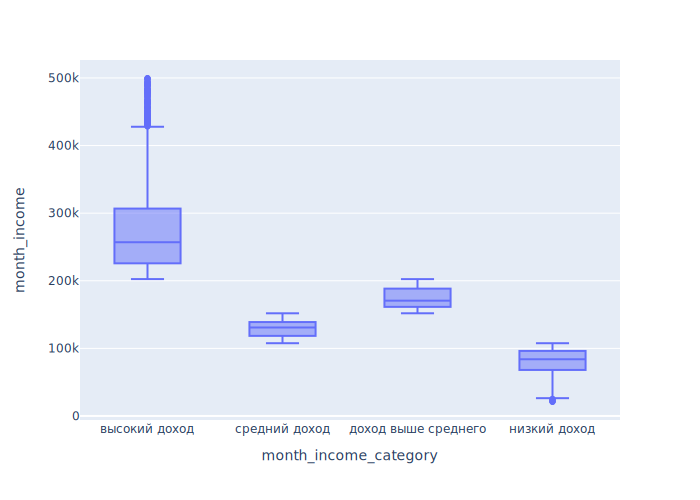

In [78]:
fig = px.box(clients.query('month_income < 500000'), x = 'month_income_category', y = 'month_income')
pio.show(fig)

In [79]:
clients['month_income_category'].value_counts()

доход выше среднего    5817
низкий доход           5364
средний доход          5363
высокий доход          4909
Name: month_income_category, dtype: int64

Eсли исходить только из показателей ежемесячного дохода, то можно сделать вывод, что больше всего кредитами пользуются люди, у которых ежемесячный доход выше среднего.
А людям с высоким доходом потребительский кредит менее интересен

#### Категоризация по целям

Ранее мы получили леммы для целей кредита и сохранили их в отдельном столбце. Эти данные будем использовать для категоризации. Посмотрим на значения, которые представлены

In [80]:
clients['purpose_lemma'].value_counts()

автомобиль\n                                972
свадьба\n                                   791
на проведение свадьба\n                     767
сыграть свадьба\n                           765
операция с недвижимость\n                   675
покупка коммерческий недвижимость\n         661
операция с жилье\n                          652
покупка жилье для сдача\n                   651
операция с коммерческий недвижимость\n      650
покупка жилье\n                             646
жилье\n                                     646
покупка жилье для семья\n                   638
строительство собственный недвижимость\n    635
недвижимость\n                              633
операция со свой недвижимость\n             627
строительство жилой недвижимость\n          624
покупка недвижимость\n                      621
покупка свой жилье\n                        620
строительство недвижимость\n                619
ремонт жилье\n                              607
покупка жилой недвижимость\n            

На основании списка можно выделить цели на четыре категории - автомобиль, свадьба, жилье/недвижимость, образование:

- автомобиль - цели, у которых встречается слово "автомобиль"
- свадьба - цели, у которых встречается слово "свадьба"
- образование - цели, у которых встречается слово "образование"
- жилье/недвижимость - цели, у которых встречаются слова "жилье" или "недвижимость". 
    
    
Дополнительно интересно будет получить данные в разрезе подкатегорий жилья/недвижимости, такую обработку мы сделаем после категоризации по четырем основным категориям. 


In [81]:
def category_purpose(row):
    purpose_lemma = row['purpose_lemma']
    try:
        for word in purpose_lemma:
            if 'автомобиль' in purpose_lemma:
                return 'автомобиль'
            if 'свадьба'in purpose_lemma:
                return 'свадьба'
            if 'образование' in purpose_lemma:
                return 'образование'
            if 'жилье' in purpose_lemma:
                return 'жилье/недвижимость'
            if 'недвижимость' in purpose_lemma:
                return 'жилье/недвижимость'
            return 'другое'
    except:
        return 'что-то пошло не так'

Сформируем строки для проверки функции, поочередно будем подставлять в них разные значения.

In [82]:
row_values = ['автомобильяяя покупка']  
row_columns = ['purpose_lemma'] 

row1 = pd.Series(data=row_values, index=row_columns) 

In [83]:
category_purpose(row1)

'автомобиль'

In [84]:
row_values = ['свадьб']  
row_columns = ['purpose_lemma'] 

row2 = pd.Series(data=row_values, index=row_columns) 

In [85]:
category_purpose(row2)

'другое'

In [86]:
row_values = [111]  
row_columns = ['purpose_lemma'] 

row3 = pd.Series(data=row_values, index=row_columns) 

In [87]:
category_purpose(row3)

'что-то пошло не так'

Функция работает корректно. Запишем результат ее работы в новый столбец. Для передачи строк в функцию применим параметр axis=1

In [88]:
clients['category_purpose'] = clients.apply(category_purpose, axis=1)

Посмотрим количество уникальных значений. Мы категоризировали данные на четыре цели. Большая часть кредитов связана с жильем/недвижимостью

In [89]:
clients['category_purpose'].value_counts()

жилье/недвижимость    10811
автомобиль             4306
образование            4013
свадьба                2323
Name: category_purpose, dtype: int64

Дополнительно интересно получить данные в разрезе подкатегорий жилья/недвижимости. Посмотрим на уникальные значения по лемматизированным целям для категории "жилье/недвижимость"

In [90]:
clients.loc[clients['category_purpose'] == 'жилье/недвижимость']['purpose_lemma'].unique()

array(['покупка жилье\n', 'операция с жилье\n',
       'покупка жилье для семья\n', 'покупка недвижимость\n',
       'покупка коммерческий недвижимость\n',
       'покупка жилой недвижимость\n',
       'строительство собственный недвижимость\n', 'недвижимость\n',
       'строительство недвижимость\n',
       'операция с коммерческий недвижимость\n',
       'строительство жилой недвижимость\n', 'жилье\n',
       'операция со свой недвижимость\n', 'покупка свой жилье\n',
       'операция с недвижимость\n', 'покупка жилье для сдача\n',
       'ремонт жилье\n'], dtype=object)

 Выделим следующие подкатегории:
   - покупка для сдачи в аренду - встречается слово "коммерческий" или "сдача"
   - строительство - встречается слово "строительство"
   - ремонт - встречается слово "ремонт"
   - покупка жилья/недвижимости - все остальные записи, не попавшие под три вышеназванные подкатегории. 

Напишем функцию, которая принимает одну строку, обрабатывает категорию и леммы в целях кредита, а затем возвращает подкатегорию. 

In [91]:
def subcategory_purpose(row):
    category_purpose = row['category_purpose']
    purpose_lemma = row['purpose_lemma']
    try:
        if category_purpose == 'жилье/недвижимость':
            if 'коммерческий' in purpose_lemma:
                return 'покупка для сдачи в аренду'
            if 'сдача' in purpose_lemma:
                return 'покупка для сдачи в аренду'
            if 'строительство' in purpose_lemma:
                return 'cтроительство'
            if 'ремонт' in purpose_lemma:
                return 'ремонт'
            return 'покупка жилья/недвижимости'
        elif category_purpose != 'жилье/недвижимость':
            return category_purpose #заполнить пропуски названиями категорий в подкатегориях, не относящихся
                                    #к жилью/недвижимости. Но для этой записи не срабатывает except,
                                    #т.к. что передаем в category_purpose,то и записывается
    except:
        return 'упс! надо разбираться с ошибкой'
                               

Сформируем строки для проверки функции

In [92]:
row_values = ['жилье/недвижимость','сдача']  
row_columns = ['category_purpose','purpose_lemma'] 

row1 = pd.Series(data=row_values, index=row_columns) 

subcategory_purpose(row1)

'покупка для сдачи в аренду'

In [93]:
row_values = ['жилье/недвижимость','что-то про жилье']  
row_columns = ['category_purpose','purpose_lemma'] 

row2 = pd.Series(data=row_values, index=row_columns) 

subcategory_purpose(row2)

'покупка жилья/недвижимости'

In [94]:
row_values = ['образование','ученье свет']  
row_columns = ['category_purpose','purpose_lemma'] 

row3 = pd.Series(data=row_values, index=row_columns) 

subcategory_purpose(row3)

'образование'

In [95]:
row_values = ['жилье/недвижимость',0]  
row_columns = ['category_purpose','purpose_lemma'] 

row3 = pd.Series(data=row_values, index=row_columns) 

subcategory_purpose(row3)

'упс! надо разбираться с ошибкой'

Запишем в таблицу clients новый столбец с подкатегориями, кототрые возвращает функция subcategory_purpose

In [96]:
clients['subcategory_purpose'] = clients.apply(subcategory_purpose, axis=1)

Посмотрим, что получилось

In [97]:
clients.groupby('category_purpose')['subcategory_purpose'].value_counts()

category_purpose    subcategory_purpose       
автомобиль          автомобиль                    4306
жилье/недвижимость  покупка жилья/недвижимости    6364
                    покупка для сдачи в аренду    1962
                    cтроительство                 1878
                    ремонт                         607
образование         образование                   4013
свадьба             свадьба                       2323
Name: subcategory_purpose, dtype: int64

Среди целей получения кредита лидеры жилье/недвижимость, автомобиль и образование. 
При этом подкатегория "покупка жилья/недвижимости" на первом месте. Это говорит о том, что чаще всего люди берут кредит на приобритение своего жилья/недвижимости, скорее всего это ипотека. 

Количество кредитов на образование сопоставимо с желанием купить автомобиль. Кроме того такие цифры говорят о высокой стоимости образования

## Влияние социальных факторов на возврат кредита в срок

Для ответа на вопросы, приведенные ниже, сделаем функцию, которая строит сводную таблицу и визуализирует ее.

In [98]:
def pivot(data, index):
    
    """
    На вход функция принимает датафрейм и признак для группировки.
    Далее строится сводная таблица с подсчетом
     - общего числа клиентов в категории (count), т.е. количество должников найдем по сумме единиц;
     - числа заемщиков (sum); 
     -  % невозврата (mean), т.е. должники деленные на общее число клиентов.     
    """
    
    pivot = data.pivot_table(
        index = index, values = 'debt_status', aggfunc = ['count', 'sum', 'mean']).reset_index()
    pivot.columns = [index, 'Кол-во клиентов', 'Кол-во должников', '% невозврата']
    display(pivot.sort_values('% невозврата', ascending = False))
    
    
    fig = px.bar(
        pivot, x = index, y = '% невозврата', color = '% невозврата', title = '% невозврата по ' + index)
    pio.show(fig)

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Применим функцию pivot() к категориям по детям

,children_group,Кол-во клиентов,Кол-во должников,% невозврата
0,есть дети,6983,647,0.092654
1,многодетные,380,31,0.081579
2,нет детей,14090,1063,0.075444


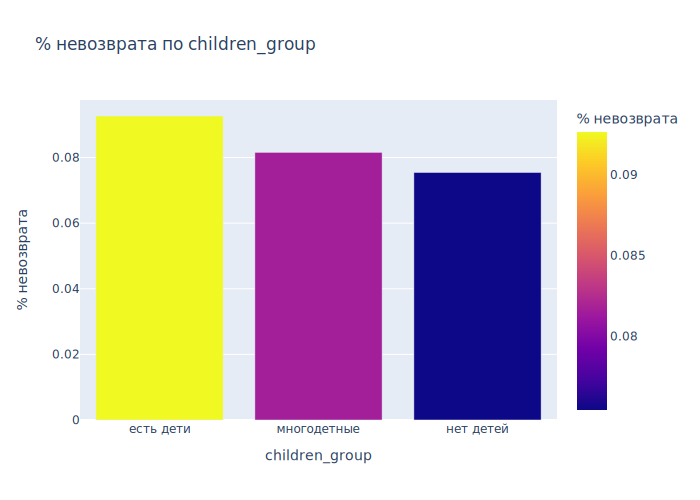

In [99]:
pivot(clients, 'children_group')

**Вывод**

Мы видим, что наличие детей влияет на возврат кредита в срок. При этом, если говорить о количестве детей, то в первую очередь должниками являются клиенты, у которых 1-2 ребенка, и только потом многодетные, от 3х детей.
Самый низкий процент невозврата из трех категорий у клиентов, которые не имеют детей.

Вероятно, наличие детей влечет дополнительные расходы, поэтому людям сложнее справиться с кредитной нагрузкой. Но тогда интересно, почему многодетные не на первом месте? Может быть дело в каких-то льготных условиях кредитования, субсидиях или они более финансово подготовлены

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Вызовем функцию pivot() для статуса по семейному положению. 

,family_status,Кол-во клиентов,Кол-во должников,% невозврата
4,не женат / не замужем,2810,274,0.097509
2,гражданский брак,4150,388,0.093494
3,женат / замужем,12339,931,0.075452
0,в разводе,1195,85,0.071130
1,вдовец / вдова,959,63,0.065693


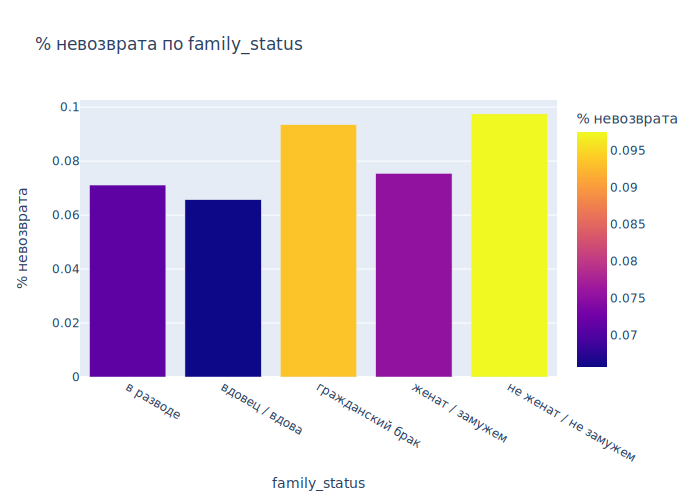

In [100]:
pivot(clients,'family_status')

**Вывод**

Семейное положение влияет на возврат кредита в срок. 
Самый высокий процент невозвратов у не женатых/не замужних, на втором месте - находящиеся в гражданском браке. Две эти категории говорят о том, что статус отношений не является официальным.

Люди, имеющие официальный статус отношений, как в настоящем (женат/замужем), так и в прошлом (в разводе, вдовец/вдова), более ответственно подходят к возврату кредитов. 

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Вызовем функцию pivot() для категорий по уровню дохода клиентов 

,month_income_category,Кол-во клиентов,Кол-во должников,% невозврата
1,средний доход,5363,475,0.088570
2,доход выше среднего,5817,494,0.084924
0,низкий доход,5364,427,0.079605
3,высокий доход,4909,345,0.070279


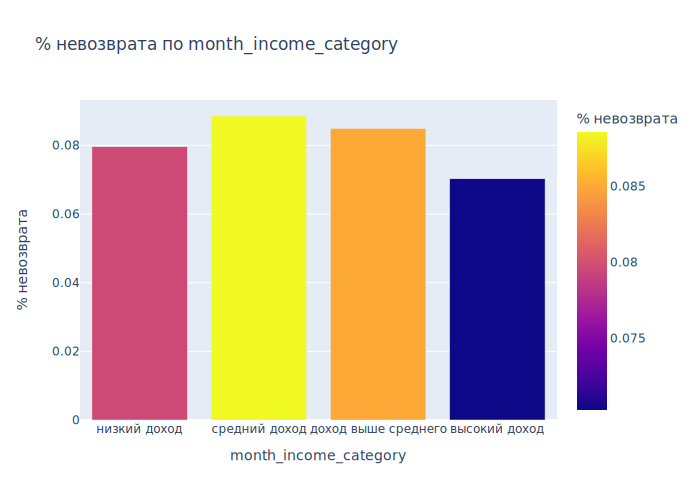

In [101]:
pivot(clients, 'month_income_category')

**Вывод**

Самый низкий процент невозврата у людей с высоким доходом.
Больше всего должников среди людей со средним доходом и чуть меньше у людей с доходом выше среднего.
Интересно, что у людей с низким доходом % невозврата ниже, чем у среднего класса. 
Можем предположить, что люди с низким доходом проходят более строкий скоринг или критически оченивают свои возможности. А средний класс не совсем корректно и слишком оптимистично оценивает свои возможности.

### Как разные цели кредита влияют на его возврат в срок?


Вызовем функцию pivot() для категорий по целям кредита. На вход передаем subcategory_purpose, чтобы увидеть более полную картину с детализацией по целям, относящимся к квартирам/недвижимости

,subcategory_purpose,Кол-во клиентов,Кол-во должников,% невозврата
1,автомобиль,4306,403,0.093590
2,образование,4013,370,0.092200
6,свадьба,2323,186,0.080069
3,покупка для сдачи в аренду,1962,151,0.076962
0,cтроительство,1878,144,0.076677
4,покупка жилья/недвижимости,6364,452,0.071025
5,ремонт,607,35,0.057661


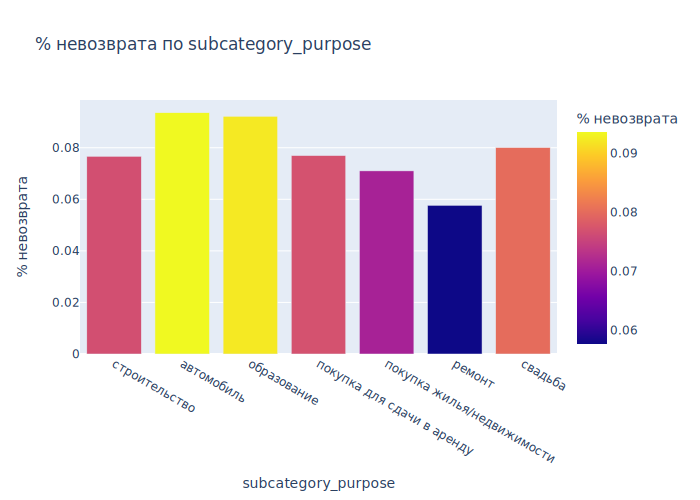

In [102]:
pivot(clients, 'subcategory_purpose')

**Вывод**

Самый высокий процент невозврата выявлен для покупки автомобиля.

Образование практически находится на одном уровне с покупкой автомобиля. И на третьем месте свадьба. 

Все остальные цели, с более низким процентом невозвратов, связанны с жильем/недвижимостью. На предпоследнем месте покупка жилья/недвижимости.
Такая статистика говорит о том, что люди в первую очередь стремятся погасить задолженность по жизненно необходимым вещам. Например, боятся что банк отберет квартиру, при этом готовы потерять автомобиль в случае непогашения кредита.
Ремонт попал на последнее место по невозвратам, т.к. скорее всего это те самые люди, которые взяли ипотеку, они хотят сделать отделку в новой квартире, обустроить ее, для них это также жизненно необходимая цель.

## Общий вывод

Мы получили наглядные данные для выявления зависимостей между возвратом кредита в срок и семейным положением, количеством детей, уровнем дохода, а также целями кредита. 
Все четыре фактора влияют на возврат кредита в срок. 

На основании полученных данных можно составить два портрета: клиент с хорошей кредитной историей и должник.

Для клиента-должника характерно следующее: официально не состоит в отношениях, есть дети, средний доход, берет кредит на автомобиль. 

Клиент с хорошей кредитной историей состоит в официальных отношениях, детей нет, высокий уровень дохода, кредит берет на собственное жилье. 